In [1]:
%matplotlib inline
import numpy as np
import pylab as pl
import time
import scipy.special as special
from scipy.integrate import quad, dblquad, fixed_quad

# Set plot parameters to make beautiful plots
pl.rcParams['figure.figsize']  = 12, 7.5
pl.rcParams['lines.linewidth'] = 1.5
pl.rcParams['font.family']     = 'serif'
pl.rcParams['font.weight']     = 'bold'
pl.rcParams['font.size']       = 20  
pl.rcParams['font.sans-serif'] = 'serif'
pl.rcParams['text.usetex']     = True
pl.rcParams['axes.linewidth']  = 1.5
pl.rcParams['axes.titlesize']  = 'medium'
pl.rcParams['axes.labelsize']  = 'large'

pl.rcParams['xtick.major.size'] = 8     
pl.rcParams['xtick.minor.size'] = 4     
pl.rcParams['xtick.major.pad']  = 8     
pl.rcParams['xtick.minor.pad']  = 8     
pl.rcParams['xtick.color']      = 'k'     
pl.rcParams['xtick.labelsize']  = 'large'
pl.rcParams['xtick.direction']  = 'in'    

pl.rcParams['ytick.major.size'] = 8     
pl.rcParams['ytick.minor.size'] = 4     
pl.rcParams['ytick.major.pad']  = 8     
pl.rcParams['ytick.minor.pad']  = 8     
pl.rcParams['ytick.color']      = 'k'     
pl.rcParams['ytick.labelsize']  = 'large'
pl.rcParams['ytick.direction']  = 'in'

In [2]:
# EVERYTHING IS 1 units

#constants
epsilon0  = 1./(4. * np.pi)
e = 4.80320680e-10
m = 9.1093826e-28
c = 2.99792458e10

epsilon  = -1.    #sign of electron charge

#parameters
B       = 1.         #background B strength
n_e     = 1.         #electron number density cm^-3
theta_e = 0.5         #dimensionless electron temp
theta   = np.pi/3.    #observer angle

#derived quantities
omega_p = np.sqrt(n_e * e**2. / (m * epsilon0))     # plasma frequency    (=1 in these units)
omega_c = e * B / (m * c)                           # cyclotron frequency (=1 in these units)

In [3]:
def K_12_prefactor(omega):
    prefactor = - 1. * omega_p**2. / (omega * omega) * 1./(4. * theta_e**2. * special.kn(2, 1./theta_e))
    return prefactor

def K_12_integrand(gamma, cos_xi, tau_prime, omega):    
    prefactor  = 1j
    beta       = np.sqrt(1. - 1./gamma**2.)
    sin_xi     = np.sqrt(1. - cos_xi**2.)
    p_perp_bar = gamma * beta * sin_xi
    p_z_bar    = gamma * beta * cos_xi
    beta_perp  = p_perp_bar / gamma
    beta_z     = p_z_bar    / gamma
    alpha      = beta * np.cos(theta) * tau_prime
    delta      = 2. * omega/(epsilon * omega_c) * np.sin(theta) * gamma * beta * np.sin(
                (epsilon * omega_c / omega) * tau_prime / (2. * gamma))
    
    gamma_term = beta**2. * np.exp(-gamma/theta_e) * np.sin((epsilon * omega_c / omega) * tau_prime / gamma)
    tau_term   = np.exp(1j * tau_prime)
    xi_term    = sin_xi**2. * np.exp(-1j * alpha * cos_xi) * special.j0(delta * sin_xi)
    ans        = prefactor * gamma_term * xi_term * tau_term
    return ans * gamma**2. * beta 

def K_32_prefactor(omega):
    prefactor = omega_p**2. / (omega * omega) * 1./(2. * theta_e**2. * special.kn(2, 1./theta_e))
    return prefactor

def K_32_integrand(gamma, cos_xi, tau_prime, omega):
    prefactor = 1.
    beta       = np.sqrt(1. - 1./gamma**2.)
    sin_xi     = np.sqrt(1. - cos_xi**2.)
    p_perp_bar = gamma * beta * sin_xi
    p_z_bar    = gamma * beta * cos_xi
    beta_perp = p_perp_bar / gamma
    beta_z    = p_z_bar    / gamma
    alpha      = beta * np.cos(theta) * tau_prime
    delta      = 2. * omega/(epsilon * omega_c) * np.sin(theta) * gamma * beta * np.sin(
                (epsilon * omega_c / omega) * tau_prime / (2. * gamma))
    
    gamma_term = beta**2. * np.exp(-gamma/theta_e) * np.sin((epsilon * omega_c / omega) * tau_prime / (2. * gamma))
    tau_term   = np.exp(1j * tau_prime)
    xi_term    = special.jn(1, delta * sin_xi) * (cos_xi * sin_xi) * np.exp(-1j * alpha * cos_xi) 
    ans        = prefactor * gamma_term * tau_term * xi_term
    return ans * gamma**2. * beta

In [4]:
gamma     = 1.5
tau_prime = 1.
omega     = omega_c

def K_12_xi_integrateda(gamma, tau_prime, omega):    
    prefactor  = 1j
    beta       = np.sqrt(1. - 1./gamma**2.)
    alpha      = beta * np.cos(theta) * tau_prime
    delta      = 2. * omega/(epsilon * omega_c) * np.sin(theta) * gamma * beta * np.sin(
                (epsilon * omega_c / omega) * tau_prime / (2. * gamma))
    
    gamma_term = beta**2. * np.exp(-gamma/theta_e) * np.sin((epsilon * omega_c / omega) * tau_prime / gamma)
    tau_term   = np.exp(1j * tau_prime)
    
    if(alpha == 0 or delta == 0):
        return 0.
    
    xi_term    = I_1_analytic(alpha, delta)
    ans        = prefactor * gamma_term * xi_term * tau_term
    return ans * gamma**2. * beta 

def I_1_integrand(x, alpha, delta):
    ans = (1. - x**2.) * np.cos(alpha * x) * special.j0(delta * np.sqrt(1. - x**2.))
    return ans

def I_1_analytic(alpha, delta):
    A     = np.sqrt(alpha**2. + delta**2.)
    minus = np.sqrt(A - alpha)
    plus  = np.sqrt(A + alpha)
    ds    = -np.sign(delta)
    outer = 2. * delta**6. / (alpha**3. * A**5. * minus**7. * plus**7.)
    inner = ((ds*2. * alpha * A**5. * (delta + ds*minus * plus)) * np.cos(alpha)
             + alpha**3. * delta * ds*(2. * alpha**2. - delta**2.) * A * np.cos(A)
             + ds*2. * alpha**4. * delta * A * np.sin(alpha)
             + ds*4. * alpha**2. * delta**3. * A * np.sin(alpha)
             + ds*2. * delta**5. * A * np.sin(alpha)
             + 2. * alpha**4. * A * minus * plus * np.sin(alpha)
             + 4. * alpha**2. * delta**2. * A * minus * plus * np.sin(alpha)
             + 2. * delta**4. * A * minus * plus * np.sin(alpha)
             - ds*alpha**3. * delta * (2. * alpha**2. + (-1. + alpha**2.) * delta**2. + delta**4.) * np.sin(A))
    ans   = outer * inner
    return ans

def K_12_xi_integrated(gamma, tau_prime, omega):
    real_part = quad(lambda cos_xi: K_12_integrand(gamma, cos_xi, tau_prime, omega).real, -1., 1.)
    imag_part = quad(lambda cos_xi: K_12_integrand(gamma, cos_xi, tau_prime, omega).imag, -1., 1.)
    ans       = real_part[0] + 1j * imag_part[0]
    return ans

print quad(lambda cos_xi: K_12_integrand(gamma, cos_xi, tau_prime, omega).imag, -1., 1.)[0]
print K_12_xi_integrateda(gamma, tau_prime, omega).imag

-0.0187707055538
-0.0187707055538


In [5]:
def n_locator(n, tau_prime, omega):
    if(n == 0):
        return 1.
    ans = omega_c * tau_prime / (n * np.pi * omega)
    if(ans < 1.):
        return 1.
    return ans

def K_12_gam_integrator(tau_prime, omega):
    gamma_limit = 5
    gamma_max   = 100.
    
    n_max = int( (omega_c * tau_prime) / (np.pi * omega) )
    n_min = int(n_max / gamma_limit) + 1
    
#    print 'n_max', n_max, n_locator(n_max, tau_prime, omega)
       
    ans   = quad(lambda gamma: K_12_xi_integrateda(gamma, tau_prime, omega), 
                 gamma_max, n_locator(n_min, tau_prime, omega))[0]

    if(np.isnan(ans)):
        ans = 0
#        print 'FIRST ONE WAS NAN', gamma_max, n_locator(n_min, tau_prime, omega), n_min
#    print 'infinity', n_locator(n_min, tau_prime, omega), ans

    for n in range(n_min, n_max):
        ans += quad(lambda gamma: K_12_xi_integrateda(gamma, tau_prime, omega), 
                    n_locator(n, tau_prime, omega), n_locator(n+1, tau_prime, omega))[0]
#        print n_locator(n, tau_prime, omega), n_locator(n+1, tau_prime, omega), ans
    
    ans += quad(lambda gamma: K_12_xi_integrateda(gamma, tau_prime, omega), 
               n_locator(n_max, tau_prime, omega), 1)[0]
#    print n_locator(n_max, tau_prime, omega), 1, ans
#    ans = 0.
    return -ans

In [9]:
def I_2_p1(alpha, delta):
    A     = np.sqrt(alpha**2. + delta**2.)
    plus  = np.sqrt(A + alpha)
    minus = np.sqrt(A - alpha)
    num   = alpha * delta**8. * (3. * A * np.cos(A) + 0.)
    denom = A**5. * minus**7. * plus**7.
    ans   = -num / denom
    return ans

def I_2_p2(alpha, delta):
    A     = np.sqrt(alpha**2. + delta**2.)
    plus  = np.sqrt(A + alpha)
    minus = np.sqrt(A - alpha)
    num   = alpha * delta**8. * (0. + (-3. + alpha**2. + delta**2.) * np.sin(A))
    denom = A**5. * minus**7. * plus**7.
    ans   = -num / denom
    return ans

def K_32_p1(gamma, tau_prime, omega):
    
    if(gamma < 1.):
#        print 'GAMMA LESS THAN 1'
        return 100.

    prefactor = 1.
    beta       = np.sqrt(1. - 1./gamma**2.)
    alpha      = beta * np.cos(theta) * tau_prime
    delta      = 2. * omega/(epsilon * omega_c) * np.sin(theta) * gamma * beta * np.sin(
                (epsilon * omega_c / omega) * tau_prime / (2. * gamma))
    gamma_term = beta**2. * np.exp(-gamma/theta_e) * np.sin((epsilon * omega_c / omega) * tau_prime / (2. * gamma))
    tau_term   = np.exp(1j * tau_prime)
    
    if(alpha == 0 or delta == 0):
        return 0.
    
#    print alpha, delta
#    xi_term    = -2j * (I_2_p1(alpha, delta) + I_2_p2(alpha, delta))
    xi_term    = -2j * (I_2_p1(alpha, delta) + 0.)
    ans        = prefactor * gamma_term * tau_term * xi_term
    
    if(delta < 0):
        #print 'HERE'
        ans = ans * -1.
    
    return ans * gamma**2. * beta


omega  = 1. * omega_c
tau    = 100.
gamma  = np.linspace(1., 10., 1000)

def n1_loc(n1, tau_prime):
    ans = omega_c * tau_prime / (2. * n1 * np.pi * omega)
    return ans


#for n1 in range(6, n1_max+1):
#    pl.axvline(n1_loc(n1, tau), color='red')
#    print n1, n1_loc(n1, tau)


def n2_loc(n2, tau_prime):
    ans = 1. / np.sqrt(1. - (n2 * np.pi / (2. * tau_prime))**2.)
    return ans

from scipy.optimize import newton, fsolve, root

guess    = 0.
rootfind = 0.



def root_locations(tau_prime, omega):
    solutions = np.empty(0)
    
    n1_min = 1
    n1_max = int(omega_c * tau / (2. * omega * np.pi))
    for n1 in range(n1_min, n1_max+1):
        sine_roots = n1_loc(n1, tau_prime)
        solutions = np.append(solutions, sine_roots)
    
    n2_max = int(2. * tau_prime / np.pi)
    n2_min = 1
    for n2 in range(n2_min, n2_max, 2):
        guess = n2_loc(n2, tau)
        rootfind = root(lambda gamma: K_32_p1(gamma, tau, omega).real, guess).x[0]
        solutions = np.append(solutions, rootfind)
    
    ans = np.unique(solutions)    
    return ans

def improved_integrator(tau_prime, omega):
    
    roots = root_locations(tau_prime, omega)
    
    ans = quad(lambda gamma: K_32_p1(gamma, tau_prime, omega).real, 1., roots[0])[0]
    temp = 0.
    for i in range(roots.size-1):
        #print roots[i], roots[i+1], ans
        temp += quad(lambda gamma: K_32_p1(gamma, tau_prime, omega).real, roots[i], roots[i+1])[0]
        if(np.isnan(temp) == True):
            temp = 0.
        ans += temp
    ans += quad(lambda gamma: K_32_p1(gamma, tau_prime, omega).real, roots[roots.size-1], np.inf)[0]

    return ans

print quad(lambda gamma: K_32_p1(gamma, tau, omega).real, 1., np.inf)[0]
print improved_integrator(tau, omega)

4.68675848705e-07


/home/alex/.local/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in divide
/home/alex/.local/lib/python2.7/site-packages/ipykernel/__main__.py:38: RuntimeWarning: invalid value encountered in multiply
/home/alex/.local/lib/python2.7/site-packages/ipykernel/__main__.py:7: RuntimeWarning: divide by zero encountered in double_scalars


7.08669616403e-07


1 1


/home/alex/.local/lib/python2.7/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in sqrt
/usr/lib/python2.7/dist-packages/numpy/lib/function_base.py:2280: ComplexWarning: Casting complex values to real discards the imaginary part
  copy=False, subok=True, dtype=otypes[0])


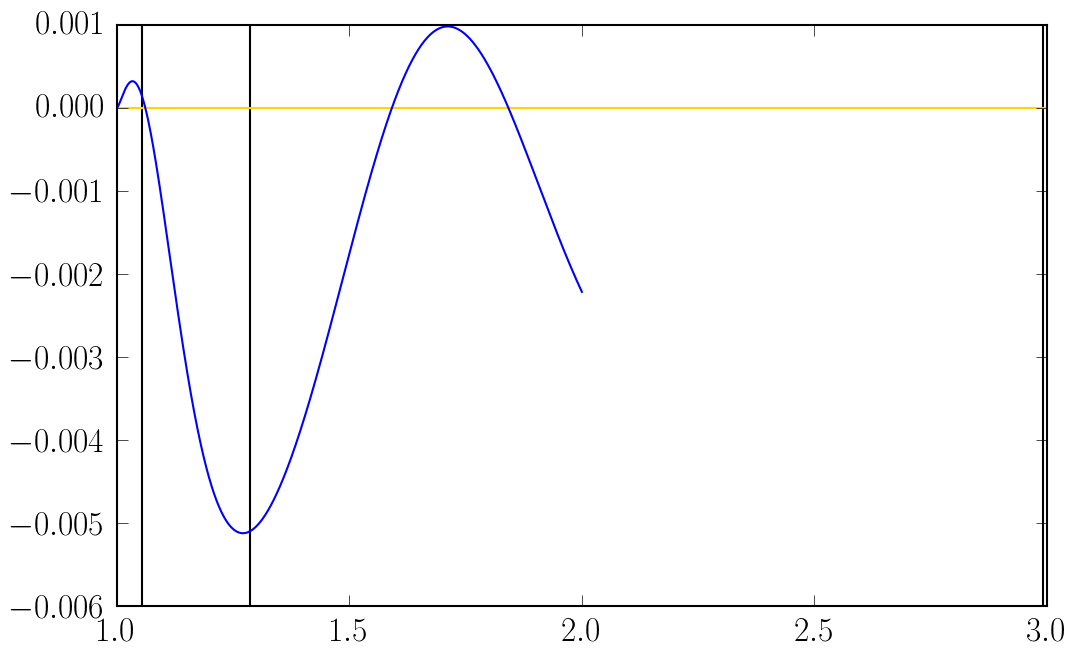

In [10]:
omega = 1. * omega_c
tau   = 10.
gamma_limit = 5.
gamma = np.linspace(1., 2, 1000)
n_max = int( (omega_c * tau) / (2. * np.pi * omega) )
n_min = int(n_max / gamma_limit) + 1

print n_min, n_max


def gamma_zero(n2):
    ans = 1. / np.sqrt(1. - (n2 * np.pi / (2. * np.cos(theta) * tau))**2.)
    return ans



#for n in range(n_min, n_max):
#    pl.axvline(n_locator(n, tau, omega), color='gold')

for n2 in range(1, 5, 1):
    pl.axvline(gamma_zero(n2), color='black')
        
pl.axhline(0, color='gold')

pl.plot(gamma, np.vectorize(K_12_xi_integrateda)(gamma, tau, omega).real)
#pl.axvline(special.jn_zeros(0, 1)[0] * 1./tau + 1.)
#print quad(lambda gamma: K_12_xi_integrateda(gamma, tau, omega), 1., 100.)
#print K_12_gam_integrator(tau, omega)

In [11]:
def K_12_normal_integrator(tau_prime, omega):
    ans = quad(lambda gamma: K_12_xi_integrateda(gamma, tau_prime, omega), 1., 100.)[0]
    return ans

omega = 1. * omega_c
tau = np.linspace(400., 430., 1000)
#gamma = np.linspace(1., 10., 1000)

time_before = time.time()
improved = np.vectorize(K_12_gam_integrator)(tau, omega)
time_after = time.time()
improved_time = time_after - time_before

time_before = time.time()
original = np.vectorize(K_12_normal_integrator)(tau, omega)
time_after = time.time()
original_time = time_after - time_before

pl.plot(tau, improved)
pl.plot(tau, original)
pl.show()
pl.plot(tau, (improved+1.)/(original+1.) - 1.)

print improved_time, original_time

/usr/local/lib/python2.7/dist-packages/scipy/integrate/quadpack.py:380: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


KeyboardInterrupt: 

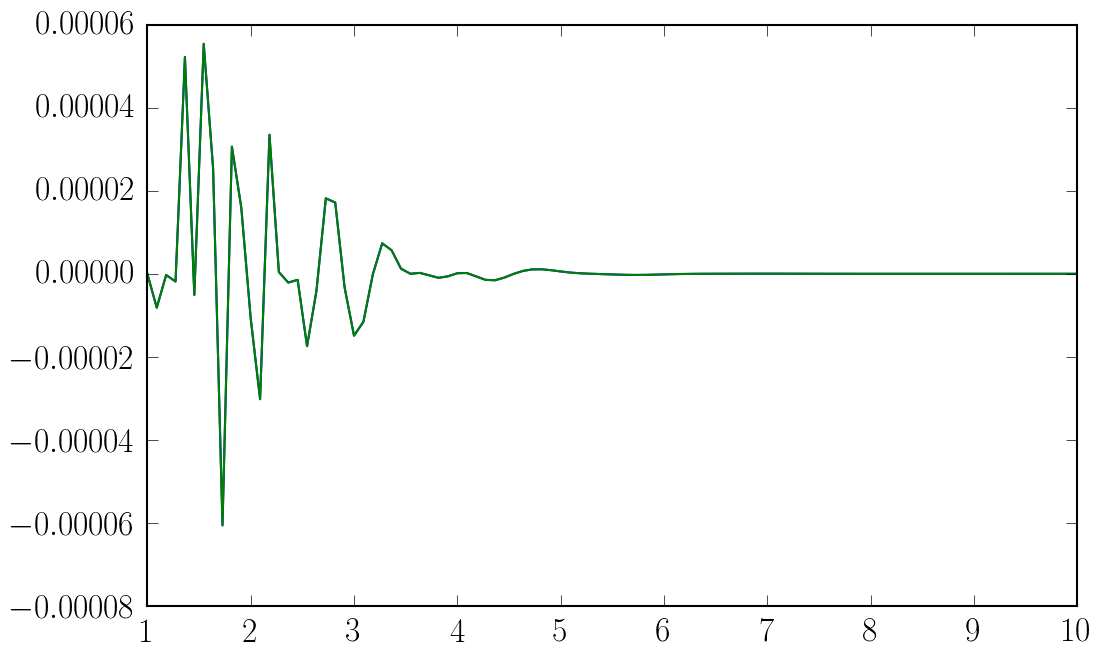

In [12]:
def I_2_analytic(alpha, delta):
    A     = np.sqrt(alpha**2. + delta**2.)
    plus  = np.sqrt(A + alpha)
    minus = np.sqrt(A - alpha)
    num   = alpha * delta**8. * (3. * A * np.cos(A) + (-3. + alpha**2. + delta**2.) * np.sin(A))
    denom = A**5. * minus**7. * plus**7.
    ans   = -num / denom
    return ans

def K_32_xi_integrateda(gamma, tau_prime, omega):
    prefactor = 1.
    beta       = np.sqrt(1. - 1./gamma**2.)
    alpha      = beta * np.cos(theta) * tau_prime
    delta      = 2. * omega/(epsilon * omega_c) * np.sin(theta) * gamma * beta * np.sin(
                (epsilon * omega_c / omega) * tau_prime / (2. * gamma))
    gamma_term = beta**2. * np.exp(-gamma/theta_e) * np.sin((epsilon * omega_c / omega) * tau_prime / (2. * gamma))
    tau_term   = np.exp(1j * tau_prime)
    
    if(alpha == 0 or delta == 0):
        return 0.
    
#    print alpha, delta
    xi_term    = -2j * I_2_analytic(alpha, delta)
    ans        = prefactor * gamma_term * tau_term * xi_term
    
    if(delta < 0):
        #print 'HERE'
        ans = ans * -1.
    
    return ans * gamma**2. * beta

def K_32_xi_integrated(gamma, tau_prime, omega):
    real_part = quad(lambda cos_xi: K_32_integrand(gamma, cos_xi, tau_prime, omega).real, -1., 1.)
    imag_part = quad(lambda cos_xi: K_32_integrand(gamma, cos_xi, tau_prime, omega).imag, -1., 1.)
    ans       = real_part[0] + 1j * imag_part[0]
    return ans

gamma = np.linspace(1., 10., 100)
tau   = 100
omega = omega_c

pl.plot(gamma, np.vectorize(K_12_xi_integrateda)(gamma, tau, omega).real)
pl.plot(gamma, np.vectorize(K_12_xi_integrated)(gamma, tau, omega).real)

(-1e-08, 1e-08)

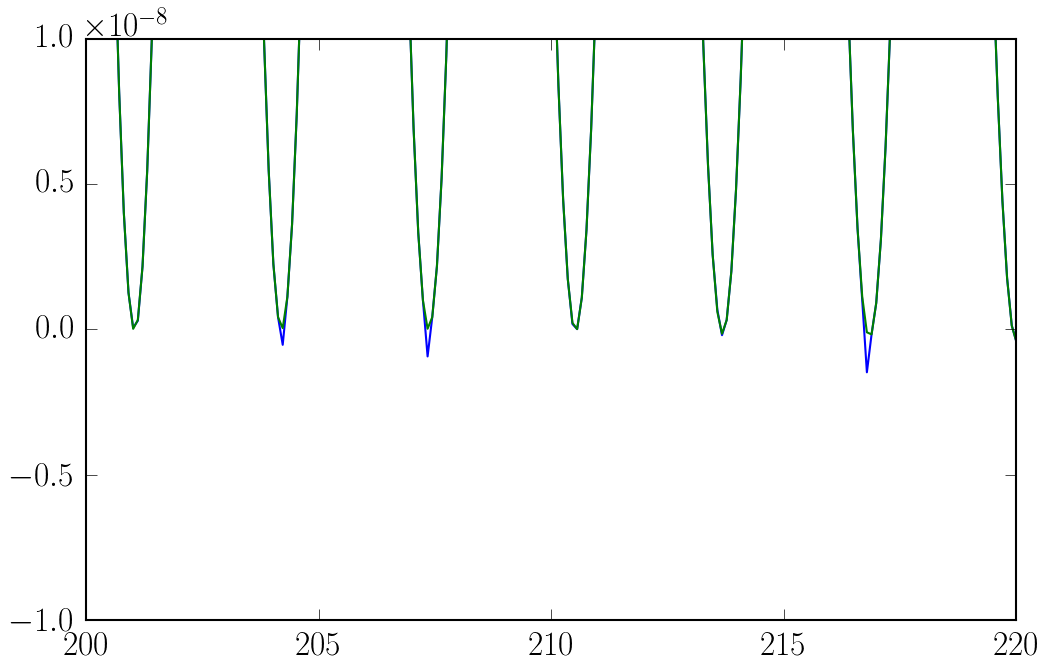

In [35]:
#gamma = np.linspace(1., 1.01, 1000)
#tau   = 420
tau   = np.linspace(200., 220., 200)
omega = 300. * omega_c

#pl.plot(gamma, np.vectorize(K_12_xi_integrateda)(gamma, tau, omega))
pl.plot(tau, np.vectorize(K_32_p_integrateda)(tau, omega))
pl.plot(tau, np.vectorize(K_32_p_integrated1)(tau, omega, 0.01, 15.))
pl.ylim([-0.1e-7, 0.1e-7])

In [32]:
def K_32_p_integrated(tau_prime, omega):
    real_part = dblquad(lambda gamma, cos_xi: K_32_integrand(gamma, cos_xi, tau_prime, omega).real, 
                       -1, 1, lambda x: 1., lambda x: np.inf)
    ans = real_part[0]
    return ans

def K_32_p_integrateda(tau_prime, omega):
    real_part = quad(lambda gamma: K_32_xi_integrateda(gamma, tau_prime, omega).real, 1., np.inf)
    ans       = real_part[0]
    return ans

def K_12_p_integrateda(tau_prime, omega):
    real_part = quad(lambda gamma: K_12_xi_integrateda(gamma, tau_prime, omega).real, 1., np.inf)
    ans       = real_part[0]
    return ans

def K_12_p_integrated1(tau_prime, omega, step_size, gamma_limit):
    start = 1.
    end   = start + step_size
    real_part = 0.
    while(end < gamma_limit):
        real_part += quad(lambda gamma: K_12_xi_integrateda(gamma, tau_prime, omega).real, start, end)[0]
        start = end
        end   += step_size
    ans       = real_part
    return ans

def K_32_p_integrated1(tau_prime, omega, step_size, gamma_limit):
    start = 1.
    end   = start + step_size
    real_part = 0.
    while(end < gamma_limit):
        real_part += quad(lambda gamma: K_32_xi_integrateda(gamma, tau_prime, omega).real, start, end)[0]
        start = end
        end   += step_size
    ans       = real_part
    return ans

In [261]:
time_before = time.time()
K_12 = fixed_quad(lambda tau: np.vectorize(K_12_p_integrateda)(tau, omega_c), 0., 60., n=55)[0]
K_32 = fixed_quad(lambda tau: np.vectorize(K_32_p_integrateda)(tau, omega_c), 0., 60., n=55)[0]
time_after  = time.time()
print 'time elapsed: ', time_after - time_before

ans = K_12 * K_12_prefactor(omega_c) * np.cos(theta) + K_32 * K_32_prefactor(omega_c) * np.sin(theta)
print 1./c * ans * omega_c

time elapsed:  0.818088054657
-6.50993548029e-10
